# Inference and prediction for linear regression

As is often the case, we will be working with a *sample*.  In the regression context, this means that our sample values of $a$ and $b$ are actually *estimates* of the true $a$ and $b$ in the population.  For clarity and consistency, those parameters are often written as the Greek letters $\alpha$ and $\beta$---and the statistics (the estimates) from our sample may be written as $\hat{\alpha}$ and $\hat{\beta}$, respectively.  As usual, the "hats" remind us we have estimates.

But recall: estimates imply *uncertainty*, and we want to quantify that uncertainty.  In particular, we to know how far off, on average, we can expect our estimates to be from the truth. 

## Data science terminology: signal and noise

Note that if we are using a linear regression to estimate the population parameters, we are assuming that there is a "true" *straight line* relationship between $X$ and $Y$ in that population.  As usual, we cannot observe it directly: it is the *signal* we want to obtain.

The problem is *noise*.  That is, random error around the signal.  This is why, in our sample, the points do not line perfectly on our regression function. 

In this context, the purpose of the regression is to *separate signal from noise*: that is, for us to work out what is systematic (and important for understanding the population) about the relationship we observe, and what is merely random error.

We will review how to make inferences in more detail below, but first let's rerun our "main" regression and define the `fit` function (again).

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
states_data = pd.read_csv("data/states_data.csv")


def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t[x])*standard_units(t[y]))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t[label_y])/np.std(t[label_x])

def intercept(t, label_x, label_y):
    return np.mean(t[label_y])-\
    slope(t, label_x, label_y)*np.mean(t[label_x])

model_slope = slope(states_data, 'cig_tax12', 'smokers12')
print("model slope...")
print(model_slope)

def fit(dframe, x, y):
    """Return the value of the regression line at each x value."""
    beta = slope(dframe, x, y)
    constant = intercept(dframe, x, y)
    return (beta*dframe[x]) + constant

model slope...
-1.5908929289147922


## Inference for the slope: bootstrapping
In principle, we could be concerned with inference for both the *intercept* and the *slope*.  But our efforts are mostly concerned with the latter.  The reason for this is because it is slope that links $x$ to $y$ directly. That is, it tells us the *effect* of $x$ of $y$, which is typically the entity we care about most when contemplating an intervention (i.e. a change to $x$).

Above, we estimated the slope for the `states` data. But that was our estimate based on particular instantiation of the data: the sample could have come out differently (say, on the day it was taken). Naturally, we would like to know *how* it could have differed had the sample been different.  And the tool we have been using for this question is the *bootstrap*.  We can use that again here.

We apply the boostrap exactly as before: 
1. we will take a random resample (of size $n$) of our data, with replacement
2. we will fit our linear model to that resample and record the value of our slope (our $b$ value)
3. we will repeat steps 1 and 2 a very large number of times

At the end, we will have a large number of slope estimates.  Plotting the *histogram* of those estimates yields the *sampling distribution* of the slope.  And from there, we can produce confidence intervals and other quantities of interest.

To see the basic idea, consider taking one (random) resample of our data and plotting the regression line for it:

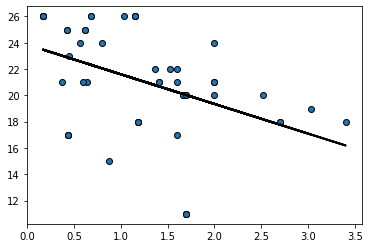

In [7]:
bootstrap_sample = states_data.sample(frac=1, replace=True)
regression_prediction_re = fit(bootstrap_sample, 'cig_tax12','smokers12')

plt.scatter(bootstrap_sample['cig_tax12'], 
            bootstrap_sample['smokers12'],  edgecolors="black")

plt.plot(bootstrap_sample['cig_tax12'], 
         regression_prediction_re, color="black", linewidth=2)

plt.show()

Let's do that a few times (9 times), and see how the line (the slope) varies each time:

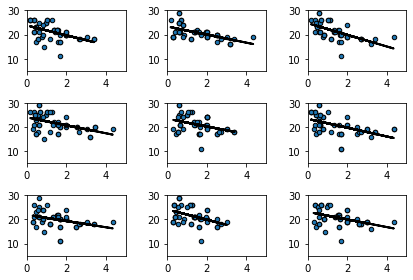

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.tight_layout()

for row in ax:
    for col in row:
        bootstrap_sample = states_data.sample(frac=1, replace=True)
        regression_prediction_re = fit(bootstrap_sample, 
                                       'cig_tax12','smokers12')

        col.scatter(bootstrap_sample['cig_tax12'], 
            bootstrap_sample['smokers12'],  edgecolors="black", s=20)
        
        col.set_xlim(0,5)
        col.set_ylim(5,30)

        col.plot(bootstrap_sample['cig_tax12'], 
         regression_prediction_re, color="black", linewidth=2)

This makes sense: for some samples, the slope is a little flatter than other samples.  

We can be more systematic by building a function to bootstrap the slope and store the results.  We then take the 95\% "middle portion" of these stored slope estimate, and that becomes our confidence interval.  At the end of the code, we draw the confidence interval onto a histogram of the sampling distribution.

In [24]:
def bootstrap_slope(dframe, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = np.array([])
    
    for i in np.arange(repetitions):
        bootstrap_sample = dframe.sample(frac=1, replace=True)
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = np.percentile(slopes, 2.5)
    right = np.percentile(slopes, 97.5)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(dframe, x, y)
    
    # Display results
    plt.hist(slopes, ec="black")
    plt.plot(([left, right]), ([0, 0]), color='yellow', lw=12, zorder=1)

    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)


For our running example (2000 bootstrap samples):

Slope of regression line: -1.5908929289147922
Approximate 95%-confidence interval for the true slope:
-2.4033106688062573 -0.8906709806306095


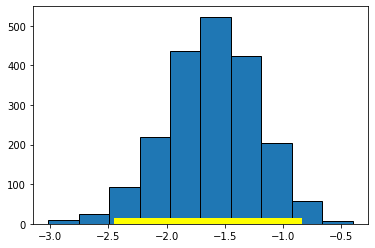

In [26]:
bootstrap_slope(states_data, "cig_tax12", "smokers12", 2000)

Here, the 95% confidence interval is something like $(-2.40, -0.89)$ (your numbers may differ slightly).  As usual, we are saying that, if we repeated this process of constructing confidence intervals many times, 95\% of those times, we would capture the true value of the parameter.  In this case, that parameter is $\beta$, the value of the slope of the population.  And, of course, we do not know whether this *particular* interval has captured it or not.

We can use the confidence interval for a *hypothesis test*.  Specifically our:
- Null Hypothesis $H_0$ is that the slope of the true population line is zero.  That is, there is no effect of cigarette tax on smoking.
- Alternative Hypothesis $H_1$ is that the slope is *not* zero.  That is, that there *is* an effect of cigarette tax on smoking.






As previously we ask: does our confidence interval contain zero?  Here, the answer is no: it is everywhere negative.  With this, we reject the null hypothesis of no effect.  Moreover, because we have the 95% confidence interval, we can say that our regression coefficient on cigarette tax is statistically significantly different to zero (at the 0.05 level).  

To see an example of a null result, consider the regression of motor vehicle fatalities per 100,000 population (`carfatal`) on alcohol consumption in gallons per capita (`alcohol`):

Slope of regression line: -1.5199403160323748
Approximate 95%-confidence interval for the true slope:
-4.061360898119362 2.299460066147436


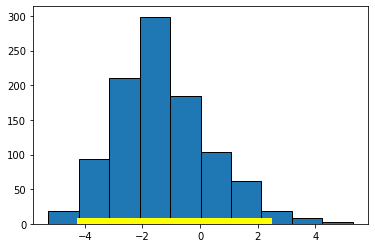

In [27]:
bootstrap_slope(states_data, 'alcohol', 'carfatal', 1000)

Here the confidence interval includes zero and we fail the reject the null hypothesis of no effect of $X$ on $Y$.

## Confidence intervals for predictions

As we showed above, it is easy to provide a *point* prediction for an observation.  We simply take the actual $x$ value and multiply it by the slope estimate and add the intercept estimate. This will give a $\hat{Y}$ for that observation, which is also called a **fitted value**. This function does that:

In [29]:
def fitted_value(dframe, x, y, given_x):
    a = slope(dframe, x, y)
    b = intercept(dframe, x, y)
    return a * given_x  + b

For example, suppose the tax rate is $5 per pack:

In [34]:
fitted_value(states_data,"cig_tax12","smokers12",5)

15.434411696205824

Then we would expect about 15% of the population of the state to smoke.  But we would like to know about the *uncertainty* around this prediction: how does it vary?

To do this, we will build a **confidence interval** for the prediction.  This is sometimes called a **predictive confidence interval** and is our **prediction of the mean response**.  We are answering the question: "what would expect to be the _average_ value of Y for a unit with these X?"

As often in data science, there is some confusing terminology here.  Note that a confidence interval is different to a *prediction interval*.  The latter are used when we are trying to predict the actual *future value* of $y$ for a given (set of) x. This is the *prediction of a future value*, or future observation.  For confidence intervals, we are asking how the *average value* of $Y$ will vary with $X$. We won't belabor the distinction here, except to note that confidence intervals are always narrower than prediction intervals.

The confidence intervals for $\hat{Y}$ depend on the particular value of $X$ we care about.  Specifically, these intervals are narrowest at the mean value of $X$.  They are widest as we move away from the mean. Basically, this  is because the regression line always goes through $\bar{X},\bar{Y}$ (the average of x and the average of y).  If you change the estimate of the slope (i.e. you are uncertain about it) that doesn't change where the line goes---it still pivots around $\bar{X},\bar{Y}$. But that means the confidence interval will be narrow near there but wider as you move away from it.

As an aside, being uncertain about the intercept *will* change  where the line goes, but that's true everywhere, and it's the slope uncertainty that forces the flaring out at the ends.

In any case, we can use our basic bootstrap procedure to produce thousands of predictions *of the average value of $Y$ for a given value of $X$*, and then plot the sampling distribution and confidence intervals for those predictions. Here is a function to help us:

In [35]:
def bootstrap_prediction(dframe, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = np.array([])
    for i in np.arange(repetitions):
        bootstrap_sample = dframe.sample(frac=1, replace=True)
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = np.percentile(predictions, 2.5)
    right = np.percentile(predictions, 97.5)
    
    # Prediction based on original sample
    original = fitted_value(dframe, x, y, new_x)
    
    # Display results
    plt.hist(predictions, ec="black")
    plt.plot(([left, right]), ([0, 0]), color='yellow', lw=12, zorder=1)
    plt.xlabel('predictions at x='+str(new_x))

    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

First, let's set the $X$ value to the *mean* of all the $X$-values:

Height of regression line at x=1.46388: 21.06
Approximate 95%-confidence interval:
20.15098017851587 21.9190316793797


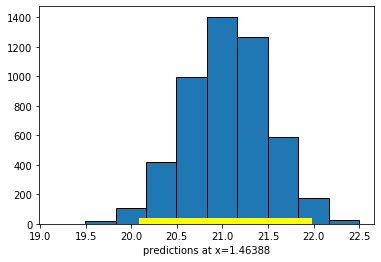

In [38]:
meanx = np.mean(states_data["cig_tax12"])
bootstrap_prediction(states_data, 'cig_tax12', 'smokers12', meanx, 5000) 

Now let's set the $X$-value to the maximum of the data:

Height of regression line at x=4.35: 16.46849210000044
Approximate 95%-confidence interval:
13.932965677157052 18.377604500908337


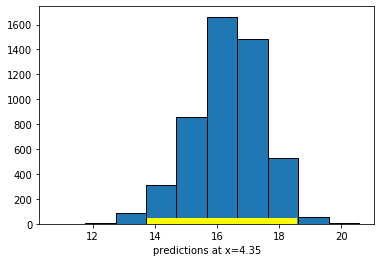

In [40]:
maxx = np.max(states_data["cig_tax12"])
bootstrap_prediction(states_data, 'cig_tax12', 'smokers12', maxx, 5000) 

Compare the widths of the confidence intervals: with $X$ near its mean, we have a confidence interval of around $(20.15, 21.92)$; with $X$ at its maximum, we have a confidence interval of around $(13.93, 18.38)$.  So the latter is much larger than the former.

In either case though, we are saying that if we repeated this way of constructing confidence intervals many many times, approximately 95% of the time we expect them to contain the true value of the mean of $\hat{Y}$ at that level of $X$.